In [2]:
from fundamental_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from photutils import CircularAperture
from photutils import aperture_photometry
import numpy as np

In [3]:
# Loading data
cube = 'J0140-0839_DATACUBE.fits'
hdu = F.open(cube)
data = hdu[1].data

In [4]:
#QSO redshift
zqso = 3.6939

#Wavelength slice (in pixels) for PSF fitting/subtraction
wave_slice=150

#Coordinate of centre of QSO (pix)
xqso = 219
yqso = 228

#Centre of the star
xqso_s = 115
yqso_s = 263

#Central wavelength for PSF fitting (ang)
lamcen_psf = 6150.0

#PSF flux scaling box size (pix)
r_psf_scale = 6

#PSF subtraction box size (pix)
#Ideally 5x seeing
r_psf_sub = 15

#Velocity search window (wrt LyA; km/s)
vmin=-11000.0
vmax=5000.0

In [5]:
nw, nx, ny = data.shape
initial_lamb = hdu[1].header['CRVAL3']

wavearr = np.arange(0.0, nw,1.0) * 1.25 + initial_lamb
ind1_lamcen_psf = int(1120 - wave_slice/2.0)
ind2_lamcen_psf = int(1120 + wave_slice/2.0)

print(wavearr[ind1_lamcen_psf], wavearr[ind2_lamcen_psf])

6056.08935546875 6243.58935546875


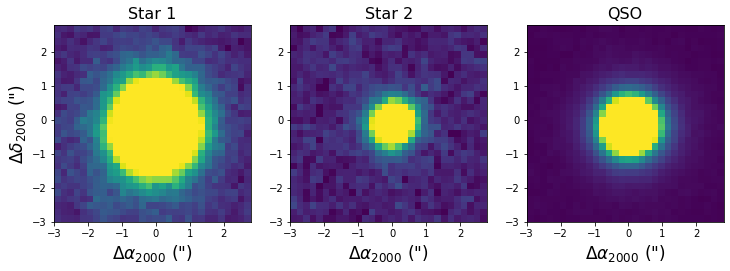

In [11]:
# Selecting the stars :D
x_s1 = 264
y_s1 = 115

x_s2 = 142
y_s2 = 191

star1_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s1-r_psf_sub):(y_s1+r_psf_sub), 
                (x_s1-r_psf_sub):(x_s1+r_psf_sub)].sum(axis=0)*1.25

star2_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s2-r_psf_sub):(y_s2+r_psf_sub), 
                (x_s2-r_psf_sub):(x_s2+r_psf_sub)].sum(axis=0)*1.25

qso_data =  data[ind1_lamcen_psf:ind2_lamcen_psf, (xqso-r_psf_sub):(xqso+r_psf_sub), 
                (yqso-r_psf_sub):(yqso+r_psf_sub)].sum(axis=0)*1.25


x = np.arange(-15,15)*0.2
y = np.arange(-15,15)*0.2

plt.figure(figsize=(12,8))

plt.subplot(131)
plt.imshow(star1_off, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.title('Star 1', fontsize=16)

plt.subplot(132)
plt.imshow(star2_off, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.title('Star 2', fontsize=16)

plt.subplot(133)
plt.imshow(qso_data, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.title('QSO', fontsize=16)

plt.show()

In [12]:
# Fitting
X, Y = np.meshgrid(x,y)
xdata = np.vstack((X.ravel(),Y.ravel()))

In [ ]:
# Performing the fitting with the double component moffat PSF (fixed theta = pi/4).
#A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set
p0_double = np.array([1e5, 1e5, 0. , 0., 1., 1., 1., 1., 0.1, 0.1, 0. ])
f = lambda X, A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set: double_moffat_integrated_func(X,  
                        A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set, np.pi/4)

param2, cov2 = curve_fit(f, xdata, star1_off.ravel(), p0=p0_double)
print('Terminó el 1er fit :D')

param3, cov3 = curve_fit(f, xdata, star2_off.ravel(), p0=p0_double)
print('Terminó el 2do fit :D')

param_QSO, cov_qso = curve_fit(f, xdata, qso_data.ravel(), p0=p0_double)
print('Terminó el fitteo')

Terminó el 1er fit :D
Terminó el 2do fit :D
Terminó el fitteo


In [ ]:
# Performing the fitting with the double component moffat PSF (unfixed theta).
#A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set
p0_double = np.array([1e5, 1e5, 0. , 0., 1., 1., 1., 1., 0.1, 0.1, 0. , np.pi/4])

param2, cov2 = curve_fit(double_moffat_integrated_func, xdata, star1_off.ravel(), p0=p0_double)
print('Terminó el 1er fit :D')

param3, cov3 = curve_fit(double_moffat_integrated_func, xdata, star2_off.ravel(), p0=p0_double)
print('Terminó el 2do fit :D')

param_QSO, cov_qso = curve_fit(double_moffat_integrated_func, xdata, qso_data.ravel(), p0=p0_double)
print('Terminó el fitteo')

Terminó el 1er fit :D
Terminó el 2do fit :D


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2600.

In [ ]:
p0 = np.array([2.52483626e+06,  9.25742332e+05, -1.71320061e-01,  4.42149865e-02,
                    -5.93407264e-01, -1.29374839e+00, -6.11682755e-01, -1.50589268e+00, 
                    2.13654269e+00,  1.18443562e+01, -1.77888359e+03, np.pi/4])

param_QSO, cov_qso = curve_fit(double_moffat_integrated_func, xdata, qso_data.ravel(), p0=p0)
print('Terminó el fitteo')

Terminó el fitteo


In [ ]:
print(param_QSO)

[ 8.56950538e+05  2.57933524e+06 -1.71336746e-01  4.42521132e-02
 -1.00993036e+00 -9.19289080e-01 -9.87848613e-01 -9.90869340e-01
  2.70918135e+00  6.19000654e+00 -8.32521251e+02  4.43170591e-01]


In [7]:
# Params found for double component (fixed center and fixed rotation)
param_s1_rot = np.array([1.13459572e+05,  3.13236886e+05, -2.00816742e-01, 
                    -3.07763246e-02, -1.87932613e+00, -7.51073213e-01, -1.70502244e+00, 
                    -7.86887415e-01, 3.39252818e+00,  2.86989315e+00,  3.15352219e+02])

param_s2_rot = np.array([-1.57159877e-05,  1.27335054e+05, -1.05251100e-01,  2.82486102e-02,
                        -3.25225587e+00,  6.89083497e-01, -1.08740734e+03,  7.18807696e-01,
                        -2.87000423e+01,  2.75078568e+00,  3.39155909e+01])

param_QSO_rot =  np.array([2.52483626e+06,  9.25742332e+05, -1.71320061e-01,  4.42149865e-02,
                    -5.93407264e-01, -1.29374839e+00, -6.11682755e-01, -1.50589268e+00, 
                    2.13654269e+00,  1.18443562e+01, -1.77888359e+03])

In [8]:
# Previously found parameters for non-double component.
param_QSO = [3.47869862e+06, -1.71284254e-01,  4.41638509e-02,  6.22461945e-01, 6.37432751e-01,  2.46842067e+00, 0.]
param_s1 = [4.18015919e+05, -2.00971753e-01, -3.07417916e-02, 7.12868901e-01, 6.84983802e-01,  1.71820283e+00, 0.]
param_s2 = [1.27500953e+05, -1.05340877e-01,  2.80799057e-02,  7.02055533e-01, 6.92711494e-01,  2.71339234e+00, 0.]

In [3]:
# Params found for double component (fixed center and unfixed rotation)
param_s1_rot_unfix = np.array([1.38280242e+05,  2.88678067e+05, -2.00800607e-01, -3.07739963e-02,
                            -1.66362353e+00, -8.25414216e-01, -1.51648123e+00, -7.81889591e-01,
                            3.01977885e+00,  3.30349786e+00,  1.90728155e+02, -9.63580783e+05])

param_s2_rot_unfix = np.array([-2.67615540e-05,  1.27326305e+05, -1.05301939e-01,  2.82307004e-02,
                            -3.49086897e+00,  7.19825007e-01, -9.74040070e+02,  6.88553561e-01,
                            -3.09889143e+01,  2.75187077e+00,  3.41756738e+01,  1.00841353e+05])

param_QSO_rot_unfix =  np.array([ 8.56950538e+05,  2.57933524e+06, -1.71336746e-01,  4.42521132e-02,
                            -1.00993036e+00, -9.19289080e-01, -9.87848613e-01, -9.90869340e-01,
                            2.70918135e+00,  6.19000654e+00, -8.32521251e+02,  4.43170591e-01])

In [13]:
# Creating the PSF with the parameters
A1, x_off1, y_off1, alpha_x1, alpha_y1, beta1, off_set1 = param_QSO
A2, x_off2, y_off2, alpha_x2, alpha_y2, beta2, off_set2 = param_s1
A3, x_off3, y_off3, alpha_x3, alpha_y3, beta3, off_set3 = param_s2

psf_s1 = moffat_integrated_func(xdata, A1, x_off1, y_off1, alpha_x1, alpha_y1, beta1, off_set1, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)
psf_s2 = moffat_integrated_func(xdata, A2, x_off2, y_off2, alpha_x2, alpha_y2, beta2, off_set2, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)
psf_s3 = moffat_integrated_func(xdata, A3, x_off3, y_off3, alpha_x3, alpha_y3, beta3, off_set3, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s1 = psf_s1.reshape(30,30)
psf_s2 = psf_s2.reshape(30,30)
psf_s3 = psf_s3.reshape(30,30)

In [14]:
# Creating the PSF for the double component Moffat. (fixed rotation)
A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso, alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso = param_QSO_rot
A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1, beta1_s1, beta2_s1, off_set_s1 = param_s1_rot
A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2, beta1_s2, beta2_s2, off_set_s2 = param_s2_rot

psf_qso_rot = double_moffat_integrated_func(xdata, A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso,
                alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s1_rot = double_moffat_integrated_func(xdata, A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1,
                beta1_s1, beta2_s1, off_set_s1, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s2_rot = double_moffat_integrated_func(xdata, A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2,
                beta1_s2, beta2_s2, off_set_s2, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_qso_rot = psf_qso_rot.reshape(30,30)
psf_s1_rot = psf_s1_rot.reshape(30,30)
psf_s2_rot = psf_s2_rot.reshape(30,30)


In [15]:
# Creating the PSF for the double component Moffat. (unfixed rotation)
A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso, alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso, theta_qso = param_QSO_rot_unfix
A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1, beta1_s1, beta2_s1, off_set_s1, theta_s1 = param_s1_rot_unfix
A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2, beta1_s2, beta2_s2, off_set_s2, theta_s2 = param_s2_rot_unfix

psf_qso_rot_unfix = double_moffat_integrated_func(xdata, A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso,
                alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso, theta_qso, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s1_rot_unfix = double_moffat_integrated_func(xdata, A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1,
                beta1_s1, beta2_s1, off_set_s1, theta_s1, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s2_rot_unfix = double_moffat_integrated_func(xdata, A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2,
                beta1_s2, beta2_s2, off_set_s2, theta_s2, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

#psf_qso_rot = psf_qso_rot.reshape(30,30)
psf_s1_rot_unfix = psf_s1_rot_unfix.reshape(30,30)
psf_s2_rot_unfix = psf_s2_rot_unfix.reshape(30,30)
psf_qso_rot_unfix = psf_qso_rot_unfix.reshape(30,30)

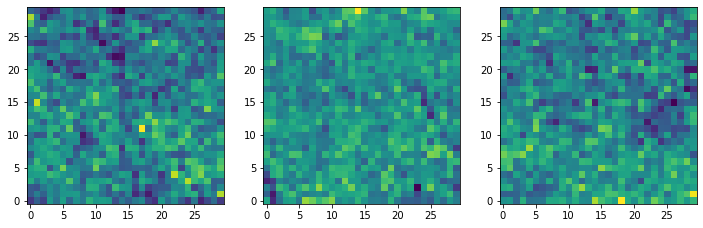

In [16]:
# Measurement of RMS sky noise near every star
sky1 = data[598:898, (xqso-r_psf_sub-50):(xqso+r_psf_sub-50), 
                (yqso-r_psf_sub):(yqso+r_psf_sub)].sum(axis=0)*1.25   # QSO sky!

sky2 = data[598:898, (y_s1-r_psf_sub-20):(y_s1+r_psf_sub-20), 
                (x_s1-r_psf_sub+40):(x_s1+r_psf_sub+40)].sum(axis=0)*1.25         # star 1 sky

sky3 = data[598:898, (y_s2-r_psf_sub-50):(y_s2+r_psf_sub-50), 
                (x_s2-r_psf_sub):(x_s2+r_psf_sub)].sum(axis=0)*1.25         # star 2 sky


RMS1 = np.sqrt(np.mean(sky1**2))
RMS2 = np.sqrt(np.mean(sky2**2))
RMS3 = np.sqrt(np.mean(sky3**2))


plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(sky1, origin='lower')
plt.subplot(132)
plt.imshow(sky2, origin='lower')
plt.subplot(133)
plt.imshow(sky3, origin='lower')
plt.show()

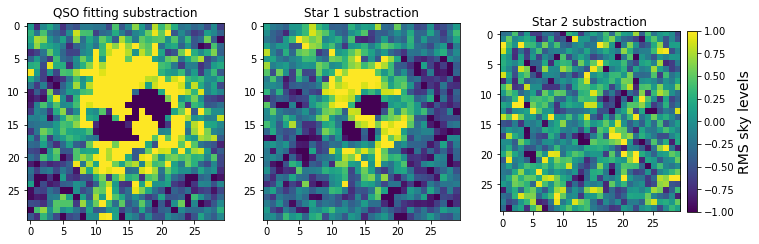

In [ ]:
# Checking the fitting
diff_qso = qso_data - psf_s1
diff_s1 = star1_off - psf_s2
diff_s2 = star2_off - psf_s3

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(diff_qso/RMS1)
plt.title('QSO fitting substraction')
plt.clim(-1,1)

plt.subplot(132)
plt.imshow(diff_s1/RMS2)
plt.title('Star 1 substraction')
plt.clim(-1,1)

plt.subplot(133)
plt.imshow(diff_s2/RMS3)
plt.title('Star 2 substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)


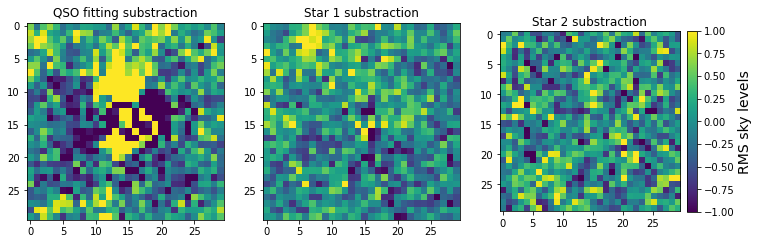

In [ ]:
# Checking the fitting (fixed rotation)
diff_qso = qso_data - psf_qso_rot
diff_s1 = star1_off - psf_s1_rot
diff_s2 = star2_off - psf_s2_rot

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(diff_qso/RMS1)
plt.title('QSO fitting substraction')
plt.clim(-1,1)

plt.subplot(132)
plt.imshow(diff_s1/RMS2)
plt.title('Star 1 substraction')
plt.clim(-1,1)

plt.subplot(133)
plt.imshow(diff_s2/RMS3)
plt.title('Star 2 substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

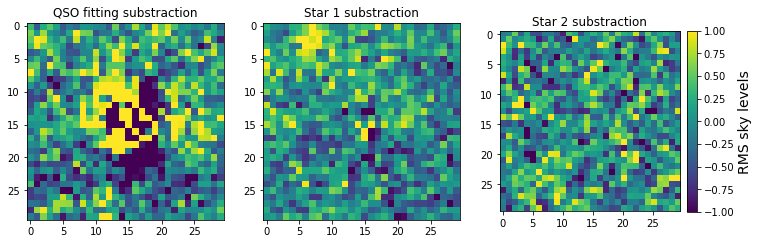

In [ ]:
# Checking the fitting (unfixed rotation)
diff_qso = qso_data - psf_qso_rot_unfix
diff_s1 = star1_off - psf_s1_rot_unfix
diff_s2 = star2_off - psf_s2_rot_unfix

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(diff_qso/RMS1)
plt.title('QSO fitting substraction')
plt.clim(-1,1)

plt.subplot(132)
plt.imshow(diff_s1/RMS2)
plt.title('Star 1 substraction')
plt.clim(-1,1)

plt.subplot(133)
plt.imshow(diff_s2/RMS3)
plt.title('Star 2 substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

In [40]:
# Getting the centers of each PSF
psfcen_1 = np.argwhere(psf_s1 == np.max(psf_s1))[0]
psfcen_2 = np.argwhere(psf_s2 == np.max(psf_s2))[0]
psfcen_3 = np.argwhere(psf_s3 == np.max(psf_s3))[0]

# PSF centers of fixed rotated double moffat.
psfcen_1_rot = np.argwhere(psf_qso_rot == np.max(psf_qso_rot))[0]
psfcen_2_rot = np.argwhere(psf_s1_rot == np.max(psf_s1_rot))[0]
psfcen_3_rot = np.argwhere(psf_s2_rot == np.max(psf_s2_rot))[0]

# PSF centers of unfixed rotated double moffat.
psfcen_1_rot_unfix = np.argwhere(psf_qso_rot_unfix == np.max(psf_qso_rot_unfix))[0]
psfcen_2_rot_unfix = np.argwhere(psf_s1_rot_unfix == np.max(psf_s1_rot_unfix))[0]
psfcen_3_rot_unfix = np.argwhere(psf_s2_rot_unfix == np.max(psf_s2_rot_unfix))[0]

#Get wavelenth of LyA at QSO redshift
wLyA = 1215.6701 * (1.0+zqso) 
#Create a search windown using minimum/maximm velocities; convert to wavelength
wmin = (1+vmin/2.998e5)*wLyA
wmax = (1+vmax/2.998e5)*wLyA

#Get indicies of this serach windown
windmin = 598
windmax = 598+243

#Get indicies in steps of wavelength slice
winds = np.arange(windmin, windmax, wave_slice)

print(wmin, wmax)

5496.865727932729 5801.401225325124


In [41]:
sub_img1, img_1, norm1 = flux_scaling(psf_s1, xqso, yqso, psfcen_1, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img2, img_2, norm2 = flux_scaling(psf_s2, y_s1, x_s1, psfcen_2, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img3, img_3, norm3 = flux_scaling(psf_s3, y_s2, x_s2, psfcen_3, winds, wave_slice, data, r_psf_sub, r_psf_scale)

sub_img1_rot, img_1_rot, norm1_rot = flux_scaling(psf_qso_rot, xqso, yqso, psfcen_1_rot, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img2_rot, img_2_rot, norm2_rot = flux_scaling(psf_s1_rot, y_s1, x_s1, psfcen_2_rot, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img3_rot, img_3_rot, norm3_rot = flux_scaling(psf_s2_rot, y_s2, x_s2, psfcen_3_rot, winds, wave_slice, data, r_psf_sub, r_psf_scale)

sub_img1_rot_unfix, img_1_rot_unfix, norm1_rot_unfix = flux_scaling(psf_qso_rot_unfix, xqso, yqso, psfcen_1_rot_unfix, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img2_rot_unfix, img_2_rot_unfix, norm2_rot_unfix = flux_scaling(psf_s1_rot_unfix, y_s1, x_s1, psfcen_2_rot_unfix, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img3_rot_unfix, img_3_rot_unfix, norm3_rot_unfix = flux_scaling(psf_s2_rot_unfix, y_s2, x_s2, psfcen_3_rot_unfix, winds, wave_slice, data, r_psf_sub, r_psf_scale)


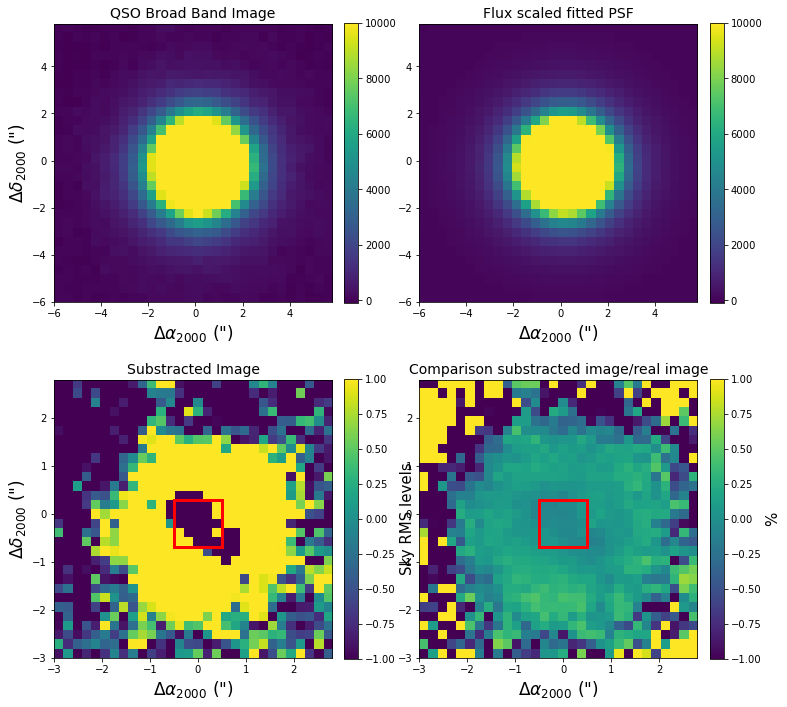

In [ ]:
x2 = np.arange(-30,30)*0.2
y2 = np.arange(-30,30)*0.2

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_1, origin='lower',extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,10000)
plt.title('QSO Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s1*norm1, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img1/RMS1, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img1/img_1, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)
plt.show()

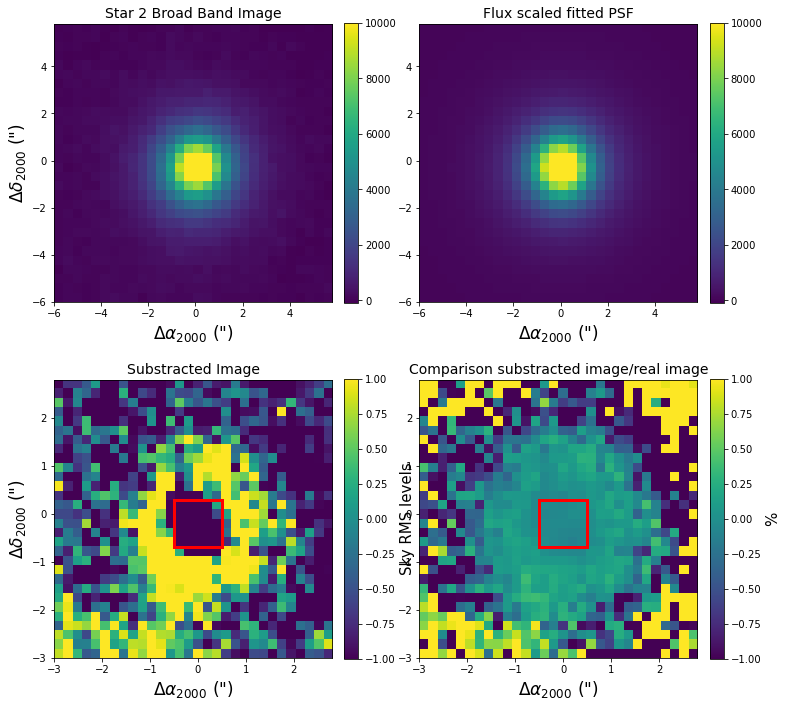

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_2, origin='lower',extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,10000)
plt.title('Star 2 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s2*norm2, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img2/RMS2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img2/img_2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)
plt.show()

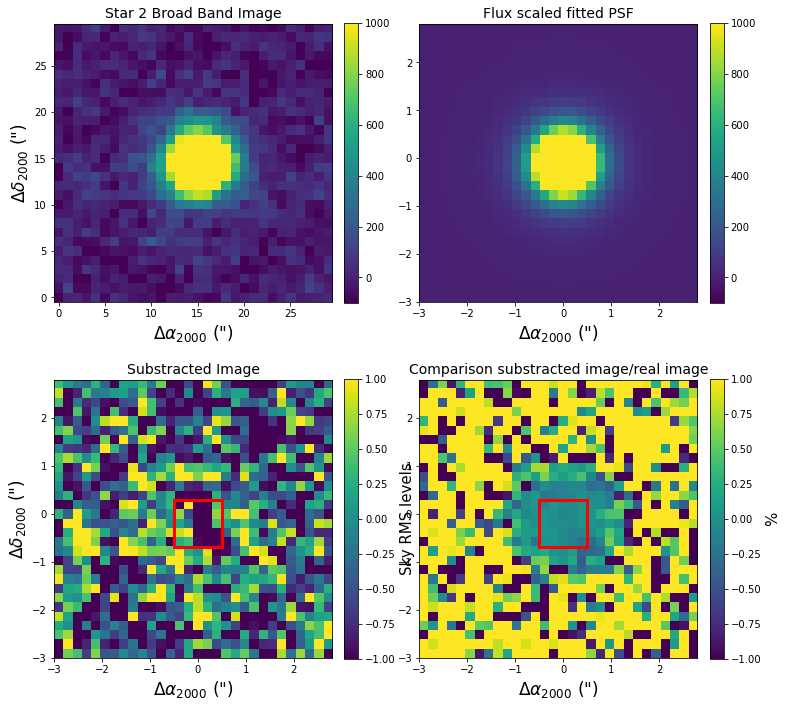

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_3, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 2 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s3*norm3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax2 = plt.subplot(223)
plt.imshow(sub_img3/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)

ax=plt.subplot(224)
plt.imshow(sub_img3/img_3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)
plt.show()

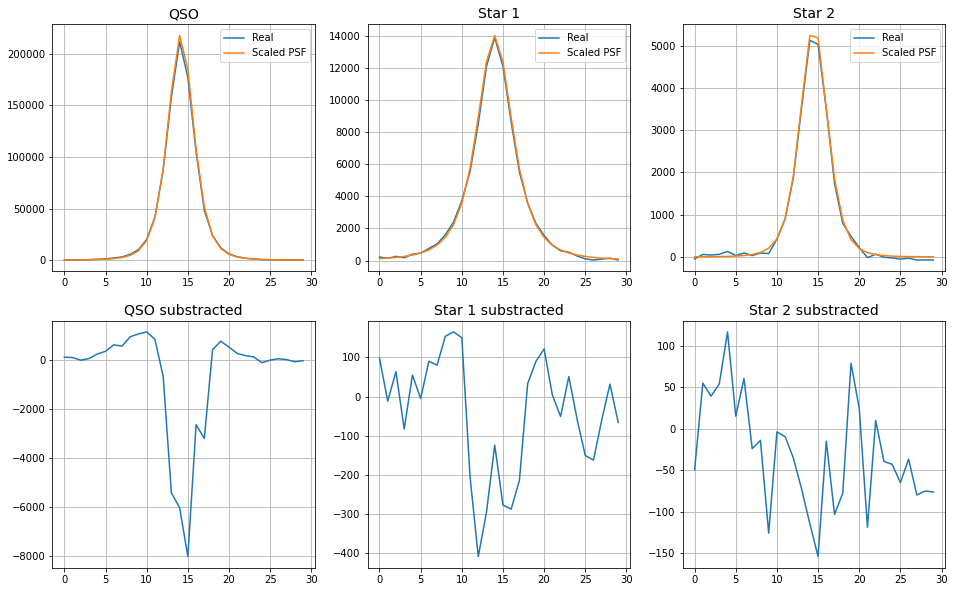

In [ ]:
# Looking how is the method working in some horizontal slices

corte_img1 = img_1[:,15]
corte_psf1 = psf_s1[:,15]

corte_img2 = img_2[:,15]
corte_psf2 = psf_s2[:,15]

corte_img3 = img_3[:,15]
corte_psf3 = psf_s3[:,15]

plt.figure(figsize=(16,10))
plt.subplot(231)
plt.plot(corte_img1, label='Real')
plt.plot(corte_psf1*norm1, label='Scaled PSF')
plt.title('QSO', fontsize=14)
plt.grid()
plt.legend()

plt.subplot(232)
plt.plot(corte_img2, label='Real')
plt.plot(corte_psf2*norm2, label='Scaled PSF')
plt.title('Star 1', fontsize=14)
plt.grid()
plt.legend()

plt.subplot(233)
plt.plot(corte_img3, label='Real')
plt.plot(corte_psf3*norm3, label='Scaled PSF')
plt.title('Star 2', fontsize=14)
plt.grid()
plt.legend()

plt.subplot(234)
plt.plot(corte_img1-corte_psf1*norm1)
plt.title('QSO substracted', fontsize=14)
plt.grid()

plt.subplot(235)
plt.plot(corte_img2-corte_psf2*norm2)
plt.title('Star 1 substracted', fontsize=14)
plt.grid()

plt.subplot(236)
plt.plot(corte_img3-corte_psf3*norm3)
plt.title('Star 2 substracted', fontsize=14)
plt.grid()
plt.show()


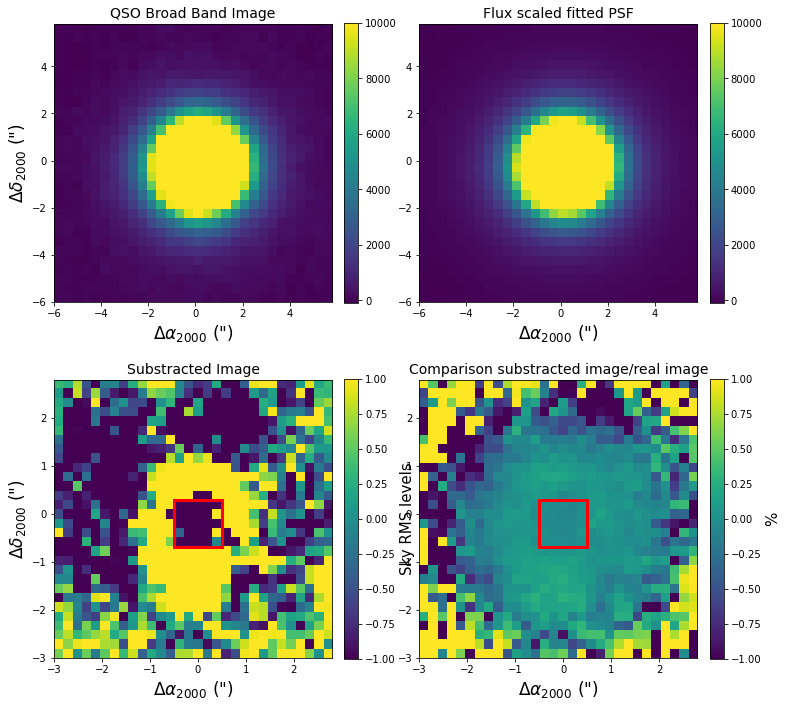

In [ ]:
# Plots for the fixed rotation double component! 

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_1_rot, origin='lower',extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,10000)
plt.title('QSO Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_qso_rot*norm1_rot, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img1_rot/RMS1, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img1_rot/img_1_rot, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)
plt.show()

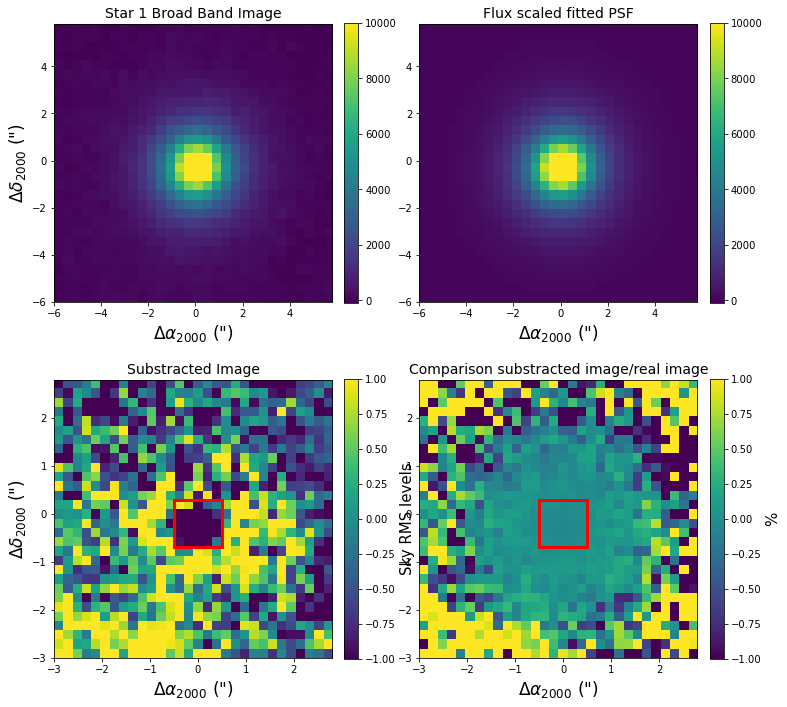

In [ ]:

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_2_rot, origin='lower',extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,10000)
plt.title('Star 1 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s1_rot*norm2_rot, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img2_rot/RMS2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img2_rot/img_2_rot, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)
plt.show()

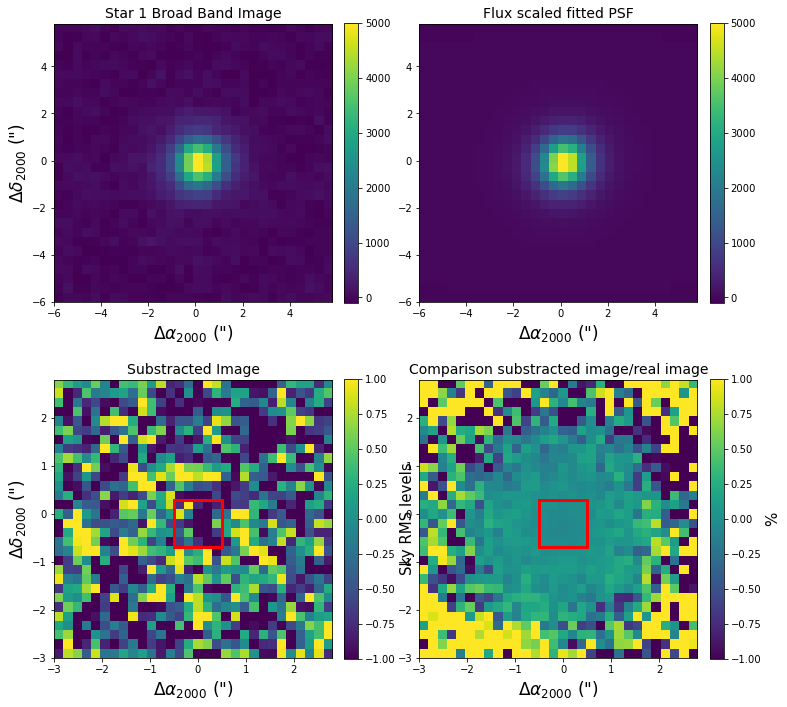

In [ ]:

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_3_rot, origin='lower',extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,5000)
plt.title('Star 1 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s2_rot*norm3_rot, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,5000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img3_rot/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img2_rot/img_2_rot, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)
plt.show()

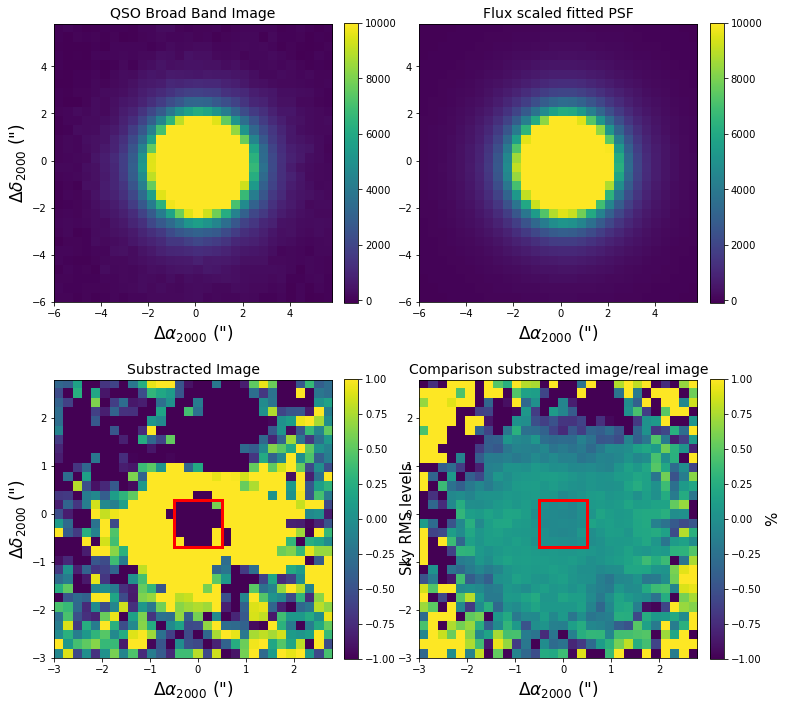

In [ ]:
# Plots for unfixed rotation component! 

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_1_rot_unfix, origin='lower',extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,10000)
plt.title('QSO Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_qso_rot_unfix*norm1_rot_unfix, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img1_rot_unfix/RMS1, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img1_rot_unfix/img_1_rot_unfix, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)
plt.show()

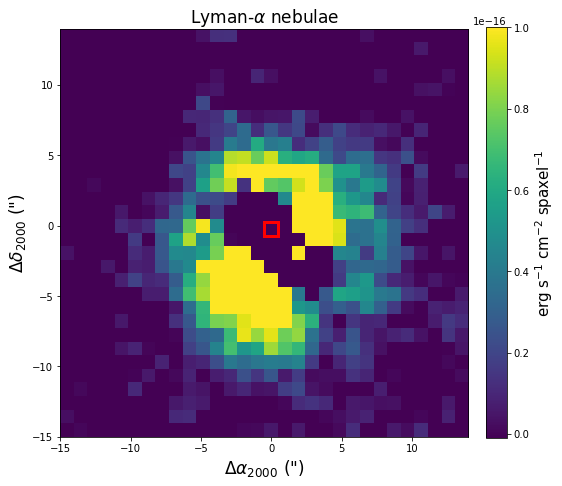

In [42]:
# Final nebula (single component)
scaling_factor = 10e-20

plt.figure(figsize=(8,8))

ax3 =plt.subplot(111)
plt.imshow(sub_img1*scaling_factor, origin='lower', extent=[x[0]/0.2,x[-1]/0.2,y[0]/0.2,y[-1]/0.2])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-10*scaling_factor,1000*scaling_factor)
cb.set_label(r'erg s$^{-1}$ cm$^{-2}$ spaxel$^{-1}$', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title(r'Lyman-$\alpha$ nebulae', fontsize=17)

plt.show()

In [21]:
from astropy.cosmology import FlatLambdaCDM
from astropy import coordinates as coord
from astropy import units as u

In [50]:
#Set the cosmology
cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)

RA_qso = "01:40:49.176"
DEC_qso = "-08:39:42.90"
coord_qso = coord.SkyCoord(ra=RA_qso, dec=DEC_qso, frame='fk5', unit=(u.hourangle, u.deg))

RA_alpha_emitter = "01:40:49.001"
DEC_alpha_emitter = "-08:40:10.30"

coord_alpha_emitter = coord.SkyCoord(ra=RA_alpha_emitter, dec=DEC_alpha_emitter, frame='fk5', unit=(u.hourangle, u.deg))

ang_sep_alpha_emitter = coord_qso.separation(coord_alpha_emitter)

scale = cosmo.arcsec_per_kpc_proper(zqso).value
rho=np.abs(ang_sep_alpha_emitter.degree/(scale/3600.0))

RA_nebulae_1 = "01:40:49.176"
DEC_nebulae_1 = "-08:39:41.90"

RA_nebulae_2 = "01:40:49.176"
DEC_nebulae_2 = "-08:39:44.90"

coord_1 = coord.SkyCoord(ra=RA_nebulae_1, dec=DEC_nebulae_1, frame='fk5', unit=(u.hourangle, u.deg))
coord_2 = coord.SkyCoord(ra=RA_nebulae_2, dec=DEC_nebulae_2, frame='fk5', unit=(u.hourangle, u.deg))

angsep = coord_1.separation(coord_2).degree

rho_2 = np.abs(angsep/(scale/3600.0))

print("The projected distance to the Ly alpha emitter from the QSO is: {:2f} kpc \nThe projected Ly alpha diameter is: {:2f} kpc".format(rho,rho_2))

The projected distance to the Ly alpha emitter from the QSO is: 202.260516 kpc 
The projected Ly alpha diameter is: 22.046655 kpc
